In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
n_samples = 500

In [ ]:
# Features influencing SOH
charge_cycles = np.random.randint(50, 1000, n_samples) # Number of charge cycles
avg_temp_c = np.random.normal(25, 5, n_samples) + (charge_cycles / 200) # Temp slightly increases with age/cycles
avg_depth_discharge = np.random.uniform(0.3, 0.9, n_samples) # Avg DoD (30% to 90%)
time_at_high_soc = np.random.uniform(0, 10, n_samples) # Hours per week spent > 95% SOC (bad for battery) (state of charge)
avg_charge_rate_c = np.random.uniform(0.5, 2.5, n_samples) # Average C-rate during charging

In [4]:
# Simulate SOH (Target Variable) - simplified model
# Degradation increases with cycles, high temp, high DoD, time at high SOC, high charge rate
initial_soh = 100
soh = initial_soh \
      - (charge_cycles * np.random.normal(0.02, 0.005, n_samples)) \
      - ((avg_temp_c - 25) * np.random.normal(0.05, 0.01, n_samples) * (avg_temp_c > 25)) \
      - (avg_depth_discharge * np.random.normal(5, 1, n_samples)) \
      - (time_at_high_soc * np.random.normal(0.1, 0.03, n_samples)) \
      - ((avg_charge_rate_c - 1) * np.random.normal(1, 0.3, n_samples) * (avg_charge_rate_c > 1)) \
      + np.random.normal(0, 0.5, n_samples) # Noise

soh = np.clip(soh, 70, 100) # Realistic SOH floor

In [5]:
# Create DataFrame
data = pd.DataFrame({
    'charge_cycles': charge_cycles,
    'avg_temp_c': avg_temp_c,
    'avg_depth_discharge': avg_depth_discharge,
    'time_at_high_soc_hrs_wk': time_at_high_soc,
    'avg_charge_rate_c': avg_charge_rate_c,
    'SOH': soh
})

print("--- Simulated Battery Feature Data (First 5 rows) ---")
print(data.head())

--- Simulated Battery Feature Data (First 5 rows) ---
   charge_cycles  avg_temp_c  avg_depth_discharge  time_at_high_soc_hrs_wk  \
0            152   19.843672             0.517836                 5.581402   
1            485   29.899978             0.320537                 5.399058   
2            910   28.723452             0.798393                 0.341878   
3            320   23.164124             0.507115                 9.866930   
4            156   26.121756             0.764301                 1.229708   

   avg_charge_rate_c        SOH  
0           2.183941  93.239244  
1           1.440638  86.966494  
2           1.504100  84.648163  
3           0.749428  91.329861  
4           1.270752  94.945771  


In [6]:
# Prepare Data for Model 
X = data.drop('SOH', axis=1)
y = data['SOH']

In [7]:
# Scaling features can be beneficial for some models, though less critical for RF
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled 


array([[-1.36861678, -1.43968821, -0.50244113,  0.23086631,  1.19665203],
       [-0.14104207,  0.35859335, -1.63971497,  0.16636394, -0.0745705 ],
       [ 1.42568241,  0.1482054 ,  1.11475351, -1.62256234,  0.03396501],
       ...,
       [ 1.64686704,  1.01843026,  0.68150661,  0.94024252,  1.19580714],
       [-0.24426156,  0.78964786, -0.21431254,  0.65619804,  0.30134769],
       [ 0.18704847, -0.45811288,  1.23082772,  0.93171126,  0.23111491]],
      shape=(500, 5))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [9]:
# Random Forest Regressor
# n_estimators: number of trees, random_state for reproducibility
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

In [10]:
# Predictions and Evaluation
y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R2): {r2:.3f}") # Proportion of variance explained by the model (closer to 1 is better)


Root Mean Squared Error (RMSE): 3.064
R-squared (R2): 0.785


In [11]:
# Feature Importance
print("\n--- Feature Importances ---")
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


--- Feature Importances ---
                   Feature  Importance
0            charge_cycles    0.913749
2      avg_depth_discharge    0.029869
4        avg_charge_rate_c    0.020628
3  time_at_high_soc_hrs_wk    0.020433
1               avg_temp_c    0.015321


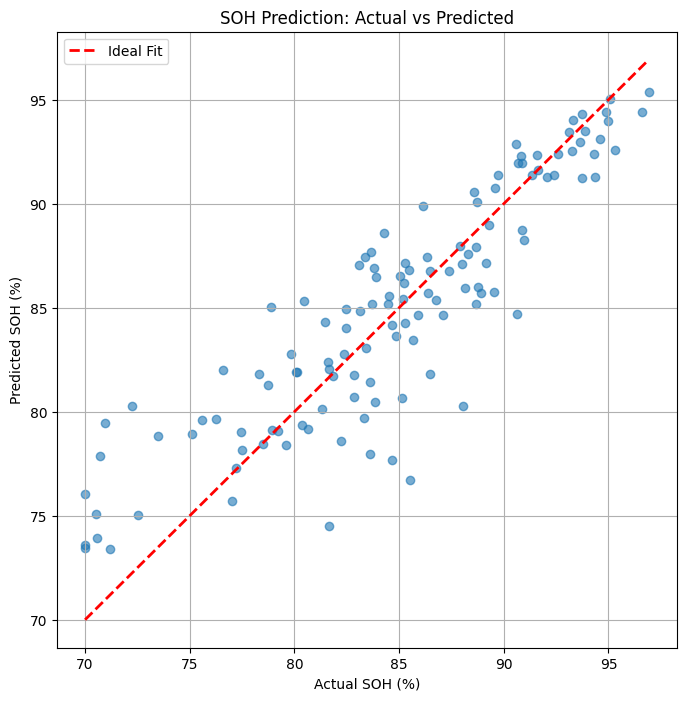

In [12]:
# Visualize Predictions vs Actuals
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual SOH (%)')
plt.ylabel('Predicted SOH (%)')
plt.title('SOH Prediction: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()